Computer Excercises for Lab 2 

In [9]:
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image


Computer Exercise 1

In [10]:
def plotcams(P, ax):
    """
    Plots the principal axes for a set of cameras.
    P: list of camera matrices where each P[i] is a 3x4 matrix representing camera i
    ax: matplotlib 3D axis for plotting
    """
    for P_i in P:
        # Calculate camera center (null space of P)
        c = scipy.linalg.null_space(P_i)
        
        # Calculate viewing direction (third row of rotation matrix)
        v = np.sign(scipy.linalg.det(P_i[:, 0:3])) * P_i[2, 0:3]
        v = v / np.linalg.norm(v)
        
        # Normalize homogeneous coordinates
        c = c / c[3]
        
        # Plot camera as arrow
        ax.quiver(c[0], c[1], c[2],
                 v[0], v[1], v[2],
                 color='red', linewidth=1.5,
                 length=5.0, normalize=True)

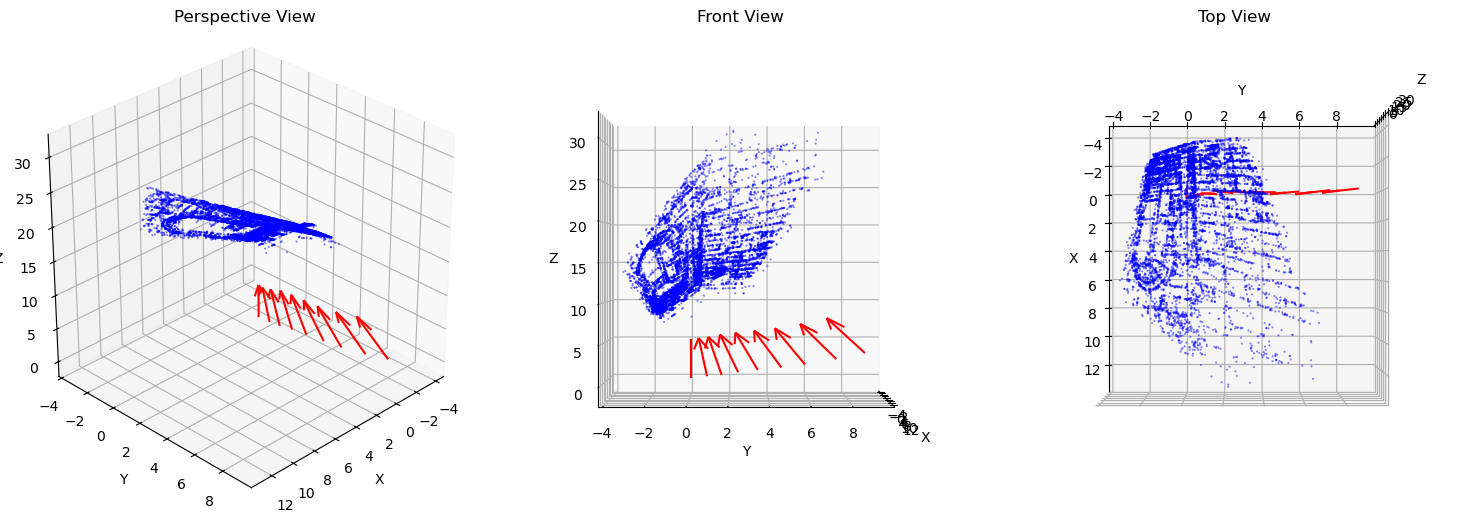

In [11]:
# COMPUTER EXERCISE 1.1
#  Load the data
data = scipy.io.loadmat('compEx1data.mat')
X = data['X']
P = data['P'][0]

# Create figure with multiple views
fig = plt.figure(figsize=(15, 5))

# Define different viewing angles
views = [(30, 45), (0, 0), (90, 0)]
titles = ['Perspective View', 'Front View', 'Top View']

# Create subplots for each view
for i, ((elev, azim), title) in enumerate(zip(views, titles), 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    
    # Plot 3D points
    x = X[0, :] / X[3, :]
    y = X[1, :] / X[3, :]
    z = X[2, :] / X[3, :]
    ax.scatter(x, y, z, c='blue', marker='.', alpha=0.5, s=1)
    
    # Plot cameras
    plotcams(P, ax)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Set specific view
    ax.view_init(elev=elev, azim=azim)
    
    # Labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)

plt.tight_layout()
plt.show()

Mean reprojection error: 0.24 pixels
Number of points detected in this camera: 4401
Total number of 3D points: 9471


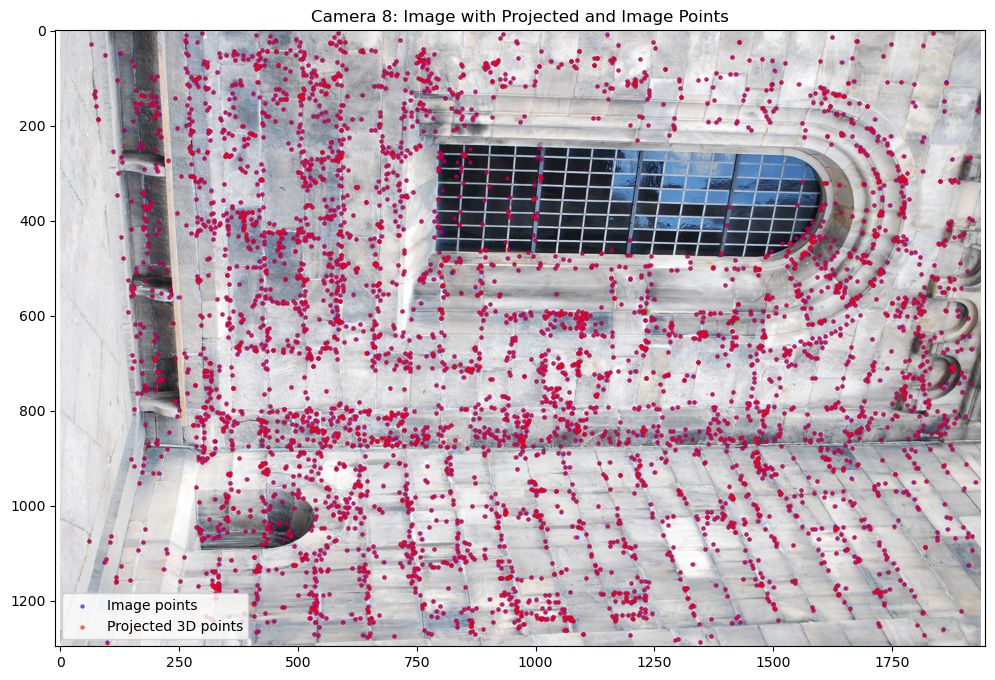

In [5]:
# COMPUTER EXERCISE 1.2
# Load missing data
P = data['P'][0]      # Camera matrices
x = data['x'][0]      # Image points
imfiles = data['imfiles'][0]  # Image filenames

# Choose camera index (e.g., first camera)
cam_idx = 7

# Get camera matrix and image points for selected camera
P_i = P[cam_idx]
x_i = x[cam_idx]

# Find points that were detected in this camera (not NaN)
valid_points = ~np.isnan(x_i[0, :])

# Project only the valid 3D points
X_valid = X[:, valid_points]  # Select only the 3D points that were detected
X_proj = P_i @ X_valid        # Project these points

# Convert to euclidean coordinates
x_proj = X_proj[0, :] / X_proj[2, :]
y_proj = X_proj[1, :] / X_proj[2, :]

# Get the corresponding image points
x_img = x_i[0, valid_points] / x_i[2, valid_points]
y_img = x_i[1, valid_points] / x_i[2, valid_points]

# Create figure
plt.figure(figsize=(12, 8))

# Load and display the image
img_filename = str(imfiles[cam_idx][0])
img = mpimg.imread(img_filename)
plt.imshow(img)



# Plot image points in blue
plt.scatter(x_img, y_img, 
           c='blue', marker='.', label='Image points', 
           s=20, alpha=0.5)

# Plot projected points in red
plt.scatter(x_proj, y_proj, 
           c='red', marker='.', label='Projected 3D points', 
           s=20, alpha=0.5)

plt.title(f'Camera {cam_idx + 1}: Image with Projected and Image Points')
plt.legend()
plt.axis('equal')

# Calculate and print statistics
error = np.sqrt((x_proj - x_img)**2 + (y_proj - y_img)**2)
mean_error = np.mean(error)
print(f'Mean reprojection error: {mean_error:.2f} pixels')
print(f'Number of points detected in this camera: {np.sum(valid_points)}')
print(f'Total number of 3D points: {X.shape[1]}')

plt.show()

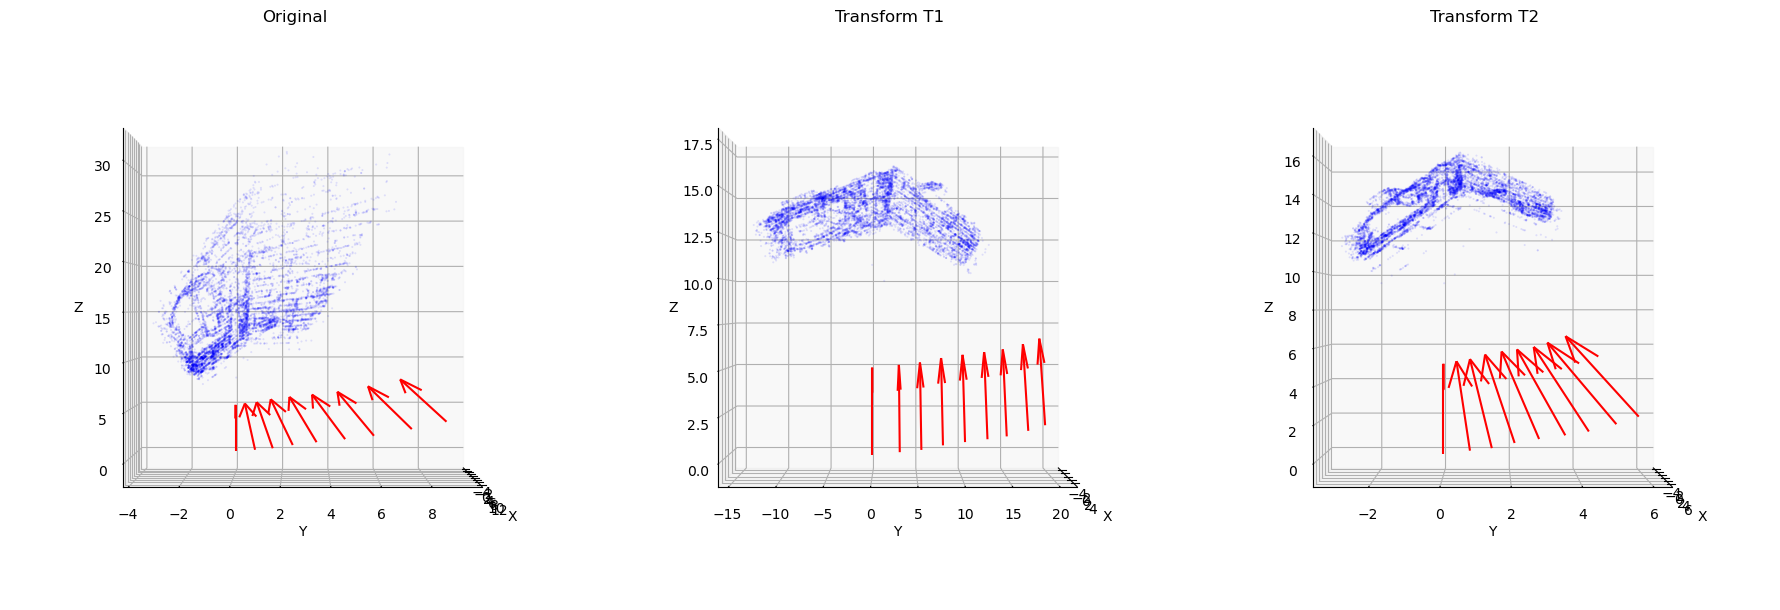


Original reconstruction statistics:
Mean position: (1.00, 0.24, 15.16)
Standard deviation: (3.44, 1.87, 4.41)

Transform T1 reconstruction statistics:
Mean position: (0.09, -0.29, 13.80)
Standard deviation: (2.69, 6.57, 1.28)

Transform T2 reconstruction statistics:
Mean position: (0.38, 0.03, 13.91)
Standard deviation: (2.79, 1.65, 1.24)


In [8]:
# COMPUTER EXERCISE 1.1

# Define the two transformations
T1 = np.array([[1, 0, 0, 0],
               [0, 4, 0, 0],
               [0, 0, 1, 0],
               [1/10, 1/10, 0, 1]])

T2 = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [1/16, 1/16, 0, 1]])

def transform_reconstruction(X, P, T):
    """Apply projective transformation to points and cameras"""
    # Transform points: X_new = T * X
    X_new = T @ X
    
    # Transform cameras: P_new = P * T^(-1)
    T_inv = np.linalg.inv(T)
    P_new = [p @ T_inv for p in P]
    
    return X_new, P_new

# Create three reconstructions
X1, P1 = transform_reconstruction(X, P, T1)
X2, P2 = transform_reconstruction(X, P, T2)

# Create figure with three subplots
fig = plt.figure(figsize=(18, 6))
titles = ['Original', 'Transform T1', 'Transform T2']
points = [X, X1, X2]
cameras = [P, P1, P2]

for i, (X_i, P_i, title) in enumerate(zip(points, cameras, titles), 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    
    # Plot 3D points (divide by homogeneous coordinate)
    x = X_i[0, :] / X_i[3, :]
    y = X_i[1, :] / X_i[3, :]
    z = X_i[2, :] / X_i[3, :]
    ax.scatter(x, y, z, c='blue', marker='.', alpha=0.1, s=1)
    
    # Plot cameras
    plotcams(P_i, ax)
    
    # Set labels and properties
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Adjust view angle
    ax.view_init(elev=0, azim=0)

plt.tight_layout()
plt.show()

# Print some statistics for each reconstruction
for i, (X_i, title) in enumerate(zip(points, titles)):
    # Convert to euclidean coordinates
    X_eucl = X_i[:3, :] / X_i[3:4, :]
    
    # Calculate some basic statistics
    mean_pos = np.mean(X_eucl, axis=1)
    std_pos = np.std(X_eucl, axis=1)
    
    print(f"\n{title} reconstruction statistics:")
    print(f"Mean position: ({mean_pos[0]:.2f}, {mean_pos[1]:.2f}, {mean_pos[2]:.2f})")
    print(f"Standard deviation: ({std_pos[0]:.2f}, {std_pos[1]:.2f}, {std_pos[2]:.2f})")

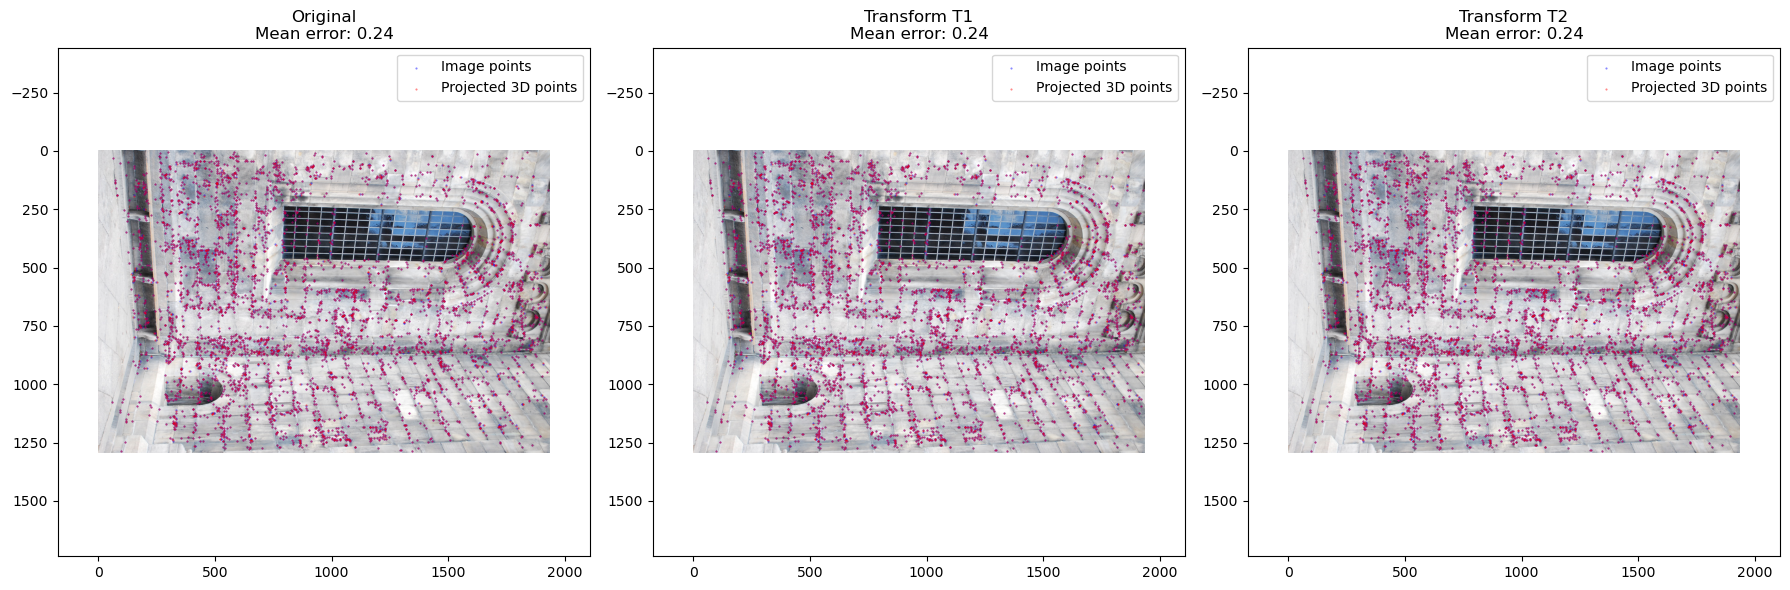


Original reconstruction:
Mean reprojection error: 0.2423
Max reprojection error: 3.8900
Min reprojection error: 0.0046

Transform T1 reconstruction:
Mean reprojection error: 0.2423
Max reprojection error: 3.8900
Min reprojection error: 0.0046

Transform T2 reconstruction:
Mean reprojection error: 0.2423
Max reprojection error: 3.8900
Min reprojection error: 0.0046


In [7]:

# COMPUTER EXERCISE 1.4

# Load the data
data = scipy.io.loadmat('compEx1data.mat')
X = data['X']
P = data['P'][0]
x = data['x'][0]
imfiles = data['imfiles'][0]

# Define transformations
T1 = np.array([[1, 0, 0, 0],
               [0, 4, 0, 0],
               [0, 0, 1, 0],
               [1/10, 1/10, 0, 1]])

T2 = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0],
               [1/16, 1/16, 0, 1]])

def transform_reconstruction(X, P, T):
    """Apply projective transformation to points and cameras"""
    X_new = T @ X
    T_inv = np.linalg.inv(T)
    P_new = [p @ T_inv for p in P]
    return X_new, P_new

# Create three reconstructions
X1, P1 = transform_reconstruction(X, P, T1)
X2, P2 = transform_reconstruction(X, P, T2)

# Choose camera index
cam_idx = 7

# Get original image points for this camera
x_i = x[cam_idx]
valid_points = ~np.isnan(x_i[0, :])

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Load and display image
img_filename = str(imfiles[cam_idx][0])
img = mpimg.imread(img_filename)

# List of reconstructions to plot
reconstructions = [
    (X, P[cam_idx], "Original"),
    (X1, P1[cam_idx], "Transform T1"),
    (X2, P2[cam_idx], "Transform T2")
]

# Plot each reconstruction
for ax, (X_curr, P_curr, title) in zip(axes, reconstructions):
    # Display image
    ax.imshow(img)
    
    # Project points that were detected in this camera
    X_valid = X_curr[:, valid_points]
    X_proj = P_curr @ X_valid
    
    # Convert to euclidean coordinates
    x_proj = X_proj[0, :] / X_proj[2, :]
    y_proj = X_proj[1, :] / X_proj[2, :]
    
    # Get original image points
    x_img = x_i[0, valid_points] / x_i[2, valid_points]
    y_img = x_i[1, valid_points] / x_i[2, valid_points]
    ax.scatter(x_img, y_img, 
              c='blue', marker='.', label='Image points', 
              s=1, alpha=0.5)
    
    # Plot points
    ax.scatter(x_proj, y_proj, 
              c='red', marker='.', label='Projected 3D points', 
              s=1, alpha=0.5)
    
    # Calculate reprojection error
    error = np.sqrt((x_proj - x_img)**2 + (y_proj - y_img)**2)
    mean_error = np.mean(error)
    
    ax.set_title(f'{title}\nMean error: {mean_error:.2f}')
    ax.legend()
    ax.axis('equal')

plt.tight_layout()
plt.show()

# Print detailed statistics
for X_curr, P_curr, title in reconstructions:
    X_valid = X_curr[:, valid_points]
    X_proj = P_curr @ X_valid
    
    x_proj = X_proj[0, :] / X_proj[2, :]
    y_proj = X_proj[1, :] / X_proj[2, :]
    
    x_img = x_i[0, valid_points] / x_i[2, valid_points]
    y_img = x_i[1, valid_points] / x_i[2, valid_points]
    
    error = np.sqrt((x_proj - x_img)**2 + (y_proj - y_img)**2)
    
    print(f"\n{title} reconstruction:")
    print(f"Mean reprojection error: {np.mean(error):.4f}")
    print(f"Max reprojection error: {np.max(error):.4f}")
    print(f"Min reprojection error: {np.min(error):.4f}")